# MMLU: Batch Size

Running MMLU benchmark involves a lot of questions. The goal here is to identify an optimal batch size.

# Setup

In [1]:
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

import jax
from jax import numpy as jnp
import rich
from rich.columns import Columns
from matplotlib import pyplot as plt
from tqdm.auto import trange, tqdm

import llama_jax as ll
from llama_jax.benchmarks.mmlu import (
    display_questions,
    download_dataset, 
    load_dataset,
    evaluate_generator,
)

In [2]:
print(f"Available devices: {jax.devices()}")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Available devices: [METAL(id=0)]


W0000 00:00:1740336647.701701   31252 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740336647.713074   31252 service.cc:145] XLA service 0x12f6ee810 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740336647.713084   31252 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740336647.714663   31252 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740336647.714676   31252 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


In [3]:
# Configure
datasets_path = Path(os.environ["PROJECT_ROOT"]) / "build" / "datasets"
mmlu_dataset_path = datasets_path / "mmlu"

# Dataset

In [4]:
download_dataset(mmlu_dataset_path)

In [5]:
dataset = load_dataset(mmlu_dataset_path)
print(f"Loaded {len(dataset.questions)} questions, {len(dataset.examples)} examples, {len(dataset.categories)} categories")

Loaded 14042 questions, 285 examples, 57 categories


# Model

In [6]:
checkpoint = "Llama3.2-3B-Instruct"

In [7]:
config = ll.checkpoint.load_config(checkpoint, max_tokens=1024)
params = ll.checkpoint.load_parameters(config)
model = ll.model.create(config, params)

In [8]:
# Pre-compile model
generator = ll.benchmarks.mmlu.generator(config, model=model)
next(generator(sample(dataset.questions, k=1)))

(Answer(qid=1040, expected='D', actual='D', scores={'A': 0.333984375, 'B': 0.1396484375, 'C': 0.039794921875, 'D': 0.484375}, correct=True),)

# Compare Batch Sizes

In [9]:
n_questions = 128
batch_sizes = [1, 2, 4, 8, 16, 32]

In [10]:
# Randomly sample questions
questions = sample(dataset.questions, k=n_questions)

tpqs = []
for bs in tqdm(batch_sizes, desc="Samples"):
    progress = tqdm(total=n_questions, desc="Questions", leave=False)

    start_time = timer()

    generator = ll.benchmarks.mmlu.generator(config, model=model, bs=bs)
    
    evaluate_generator(generator, questions=questions, progress=progress)
    
    duration = ((timer() - start_time) / 1000000000)

    tpqs.append(duration / n_questions)

Samples:   0%|          | 0/6 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

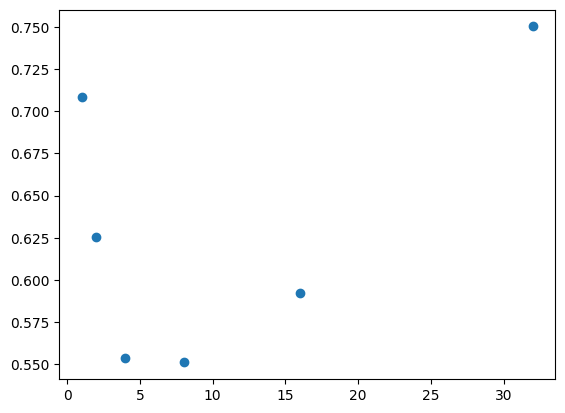

In [11]:
plt.scatter(batch_sizes, tpqs)

# Summary

Seems pretty clear that the time per question bottoms out around batch size of 8 before climbing again. 